In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import ibis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Connection

In [3]:
ibis.options.interactive = True
ibis.options.sql.default_limit = None

In [4]:
host = os.environ.get("DBPLOT_TEST_POSTGRES_HOST", "localhost")
user = os.environ.get("DBPLOT_TEST_POSTGRES_USER", "postgres")
password = os.environ.get("DBPLOT_TEST_POSTGRES_PASSWORD")
database = os.environ.get("DBPLOT_TEST_POSTGRES_DATABASE", "nycflights13") 

In [5]:
con = ibis.postgres.connect(host=host, database=database, user=user, password=password)
con.list_tables()

['airlines', 'airports', 'flights', 'planes']

In [6]:
flights = con.table("flights")

Arguments

In [7]:
nbins = 10
table = flights
column = "dep_time"

## Numpy

In [8]:
arr = table[column].execute().values

In [9]:
arr

array([517., 533., 542., ...,  nan,  nan,  nan])

In [10]:
arr = arr[np.isnan(arr) == False]

In [11]:
arr.min(), arr.max()

(1.0, 2400.0)

In [12]:
np.histogram(arr, bins=nbins)

(array([ 1160,   324, 35630, 61071, 33241, 42503, 55711, 50269, 40484,
         8128]),
 array([1.0000e+00, 2.4090e+02, 4.8080e+02, 7.2070e+02, 9.6060e+02,
        1.2005e+03, 1.4404e+03, 1.6803e+03, 1.9202e+03, 2.1601e+03,
        2.4000e+03]))

(array([ 1160.,   324., 35630., 61071., 33241., 42503., 55711., 50269.,
        40484.,  8128.]),
 array([1.0000e+00, 2.4090e+02, 4.8080e+02, 7.2070e+02, 9.6060e+02,
        1.2005e+03, 1.4404e+03, 1.6803e+03, 1.9202e+03, 2.1601e+03,
        2.4000e+03]),
 <a list of 10 Patch objects>)

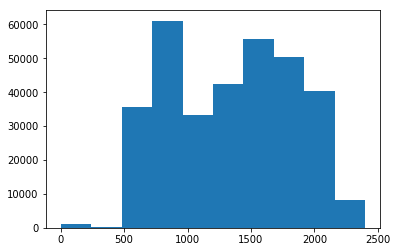

In [13]:
plt.hist(arr, bins=nbins)

## Ibis

In [14]:
table.limit(1)

   year  month  day  dep_time  dep_delay  arr_time  arr_delay carrier tailnum  \
0  2013      1    1       517          2       830         11      UA  N14228   

   flight origin dest  air_time  distance  hour  minute  
0    1545    EWR  IAH       227      1400     5      17  

In [15]:
min_, max_ = table[column].min().execute(), table[column].max().execute()
min_, max_ = float(min_), float(max_)  # From numpy.float to python.float
min_, max_

(1.0, 2400.0)

In [16]:
binwidth = (max_ - min_) / (nbins)
binwidth

239.9

In [17]:
buckets = [min_ + i * binwidth for i in range(nbins + 1)]
buckets

[1.0,
 240.9,
 480.8,
 720.7,
 960.6,
 1200.5,
 1440.4,
 1680.3,
 1920.2,
 2160.1,
 2400.0]

In [18]:
table[column].count()

328521

In [19]:
n_nulls = table[table[column] == ibis.null()].count()
n_nulls

8255

In [20]:
bucketed = table[table[column] != ibis.null()].dep_time.bucket(buckets).name("bucket")

In [21]:
bucket_counts = bucketed.value_counts().execute()
bucket_counts

,bucket,count
0,0,1160
1,1,324
2,2,35630
3,3,61071
4,4,33241
5,5,42503
6,6,55711
7,7,50269
8,8,40484
9,9,8128


In [22]:
weights = bucket_counts["count"].values
weights

array([ 1160,   324, 35630, 61071, 33241, 42503, 55711, 50269, 40484,
        8128])

In [23]:
x = np.linspace(buckets[0], buckets[-1], len(weights))
x

array([1.00000000e+00, 2.67555556e+02, 5.34111111e+02, 8.00666667e+02,
       1.06722222e+03, 1.33377778e+03, 1.60033333e+03, 1.86688889e+03,
       2.13344444e+03, 2.40000000e+03])

In [24]:
len(weights), len(x), len(buckets)

(10, 10, 11)

(array([ 1160.,   324., 35630., 61071., 33241., 42503., 55711., 50269.,
        40484.,  8128.]),
 array([1.0000e+00, 2.4090e+02, 4.8080e+02, 7.2070e+02, 9.6060e+02,
        1.2005e+03, 1.4404e+03, 1.6803e+03, 1.9202e+03, 2.1601e+03,
        2.4000e+03]),
 <a list of 10 Patch objects>)

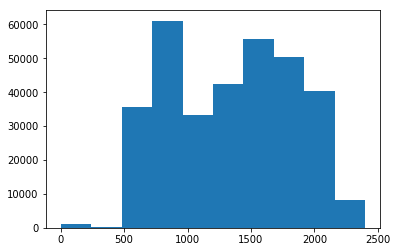

In [25]:
plt.hist(x, len(x), weights=weights)